In [1]:
import pandas as pd
import os
from pyhive import hive
import datetime

from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from lightgbm import LGBMClassifier, plot_metric
import shap

import random
import pickle

In [2]:
random_state = 42
random.seed(random_state)

In [3]:
WORK_DIR = "test1/ad-hoc_projects/consulters_11_june_2022"

In [4]:
def get_connection_hive(USER, PATH_KEYTAB, SCHEMA='dev_dm_ads', hive_config={'tez.queue.name': 'dm'}, kinit=True):
    try:
        if kinit:
            os.system(f'kinit -V -k -t {PATH_KEYTAB}/{USER}.keytab {USER}@DH.RT.RU')
            connection = hive.connect(host='ng-adh-prod-m-1.dh.rt.ru',
                                port=10000,
                                database=f'{SCHEMA}',
                                username=f'{USER}',
                                auth='KERBEROS',
                                kerberos_service_name='hive',
                                configuration = hive_config)
        print('Connection: True')
        return connection
    except Exception as e:
        print(e)
        print('Connection: False (Check Kerberos Ticket)')

In [4]:
period_keys = ('2020-12-01', '2021-05-01', '2021-10-01')
names = ('train', 'valid', 'predict')
for period_key, name in zip(period_keys, names):
    print(period_key, name)

2020-12-01 train
2021-05-01 valid
2021-10-01 predict


In [6]:
for period_key, name in zip(period_keys, names):
    start_time = datetime.datetime.now()
    print(start_time.strftime("%H:%M:%S"))
    print(period_key, name)
    with open(f'{WORK_DIR}/query.sql', 'r', encoding='utf-8') as file:
        sql_query = file.read()   
    sql_query = sql_query.replace('${period_key}', period_key)
    connection = get_connection_hive("dm-dev-adh", "test1/keytab")
    try:
        print('Starting query')
        tmp_df = pd.read_sql(sql_query, connection)
    finally:
        connection.close
    print('Query succeded')
    print(tmp_df.shape)
    tmp_df.to_csv(f'{WORK_DIR}/data/dataset_{name}.csv', index=False)
    end_time = datetime.datetime.now()
    print(f'Time elapsed {(end_time - start_time).total_seconds():.1f}s')

00:08:09
2020-12-01 train
Connection: True
Starting query
Query succeded
(191377, 4371)
Time elapsed 3323.0s
01:03:32
2021-05-01 valid
Connection: True
Starting query
Query succeded
(195622, 4371)
Time elapsed 3492.1s
02:01:44
2021-10-01 predict
Connection: True
Starting query
Query succeded
(193497, 4371)
Time elapsed 3401.0s


Не забыть также выкачать лейблы, потом при сохранении датасета их присоединить

Область - Воронежская

In [5]:
for period_key, name in zip(period_keys, names):
    start_time = datetime.datetime.now()
    print(start_time.strftime("%H:%M:%S"))
    print(period_key, name)
    sql_query = """select nls, label from dev_dm_ads.actual_churn_report
                    where mrf_key=11
                    and period_key = '${period_key}'"""
    sql_query = sql_query.replace('${period_key}', period_key)
    connection = get_connection_hive("dm-dev-adh", "test1/keytab")
    try:
        print('Starting query')
        tmp_df = pd.read_sql(sql_query, connection)
    finally:
        connection.close
    print('Query succeded')
    print(tmp_df.shape)
    tmp_df.to_csv(f'{WORK_DIR}/data/labels_{name}.csv', index=False)
    end_time = datetime.datetime.now()
    print(f'Time elapsed {(end_time - start_time).total_seconds():.1f}s')

14:30:49
2020-12-01 train
Connection: True
Starting query
Query succeded
(1672762, 2)
Time elapsed 16.5s
14:31:05
2021-05-01 valid
Connection: True
Starting query
Query succeded
(1733684, 2)
Time elapsed 16.9s
14:31:22
2021-10-01 predict
Connection: True
Starting query
Query succeded
(1743958, 2)
Time elapsed 20.9s


In [6]:
def exclude_features(df):
    exclude_name = ['nls', 'mrf_key']
    df.drop(df.dtypes[df.dtypes == 'object'].index, axis=1, inplace=True)
    df.drop(exclude_name, axis=1, inplace=True)
    return df

In [7]:
# Попробовать и этот вариант
def columns_to_drop(df): #удаление колоннок с ликами, типа объект
    leak_del = [x for x in df.columns if x.startswith('charg_inst') or x.startswith('charg_sale')]
    leak_del = leak_del + [_ for _ in df.columns if _.startswith('hgid') or _.startswith('hflat') or _.startswith('hlid')]
    leak_del = leak_del + ['latitude_1m', 'longitude_1m', 'nls_1m']
    categorical_columns = list(df.select_dtypes(include='object').columns) 
#     categorical_columns.remove('period_key')
#     categorical_columns.remove('type_sample')
#     missing_values_columns = list(df.isnull().sum()[df.isnull().sum()>50000].keys())
    
    print(f'number of columns to drop: {len(leak_del + categorical_columns)}')
    return leak_del + categorical_columns

In [197]:
df_train = pd.read_csv(f'{WORK_DIR}/data/dataset_train.csv')
df_train.columns = [c.split('.')[1] if '.' in c else c for c in list(df_train.columns)]
labels_train = pd.read_csv(f'{WORK_DIR}/data/labels_train.csv')
df_train = df_train.merge(labels_train, on='nls', how='inner')
# df_train = exclude_features(df_train)
drop_cols = columns_to_drop(df_train)
df_train.drop(drop_cols, axis=1, inplace=True)
print(df_train.shape)

number of columns to drop: 71
(160461, 4301)


In [198]:
df_valid = pd.read_csv(f'{WORK_DIR}/data/dataset_valid.csv')
df_valid.columns = [c.split('.')[1] if '.' in c else c for c in list(df_valid.columns)] 
labels_valid = pd.read_csv(f'{WORK_DIR}/data/labels_valid.csv')
df_valid = df_valid.merge(labels_valid, on='nls', how='inner')
# df_valid = exclude_features(df_valid)
df_valid.drop(drop_cols, axis=1, inplace=True)
print(df_valid.shape)

(173304, 4301)


In [199]:
df_test = pd.read_csv(f'{WORK_DIR}/data/dataset_predict.csv')
df_test.columns = [c.split('.')[1] if '.' in c else c for c in list(df_test.columns)] 
labels_test = pd.read_csv(f'{WORK_DIR}/data/labels_predict.csv')
df_test = df_test.merge(labels_test, on='nls', how='inner')
df_test.drop(drop_cols, axis=1, inplace=True)
print(df_test.shape)

(177376, 4301)


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[1]	training's auc: 0.63868	valid_0's auc: 0.616385
[2]	training's auc: 0.678178	valid_0's auc: 0.646211
[3]	training's auc: 0.690405	valid_0's auc: 0.654129
[4]	training's auc: 0.698642	valid_0's auc: 0.657323
[5]	training's auc: 0.707182	valid_0's auc: 0.662003
[6]	training's auc: 0.712192	valid_0's auc: 0.663672
[7]	training's auc: 0.715876	valid_0's auc: 0.664499
[8]	training's auc: 0.719529	valid_0's auc: 0.666455
[9]	training's auc: 0.721797	valid_0's auc: 0.666713
[10]	training's auc: 0.725814	valid_0's auc: 0.667279
[11]	training's auc: 0.728637	valid_0's auc: 0.667803
[12]	training's auc: 0.733262	valid_0's auc: 0.667663
[13]	training's auc: 0.736003	valid_0's auc: 0.668186
[14]	training's auc: 0.738875	valid_0's auc: 0.668022
[15]	training's auc: 0.742172	valid_0's auc: 0.668691
[16]	training's auc: 0.745869	valid_0's auc: 0.66864
[17]	training's auc: 0.748801	valid_0's auc: 0.669281
[18]	training's auc: 0.751376	valid_0's auc: 0.669527
[19]	training's auc: 0.754216	valid_0's

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='auc'>

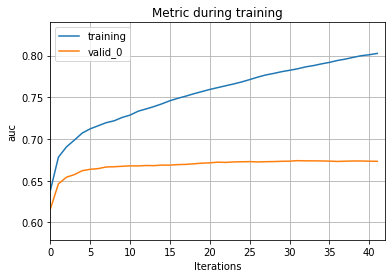

In [200]:
X_train, y_train = df_train.drop(columns=['label']), df_train.label
X_val, y_val = df_valid.drop(columns=['label']), df_valid.label
X_test, y_test = df_test.drop(columns=['label']), df_test.label
lgbm_clf = LGBMClassifier(objective='binary', metric='auc',
#                           class_weight='balanced',
                          random_state=random_state)

lgbm_clf.fit(X_train, y_train, eval_set=[(X_val, y_val), (X_train, y_train)], eval_metric='auc'
            , verbose=True, early_stopping_rounds=10)

plot_metric(lgbm_clf)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


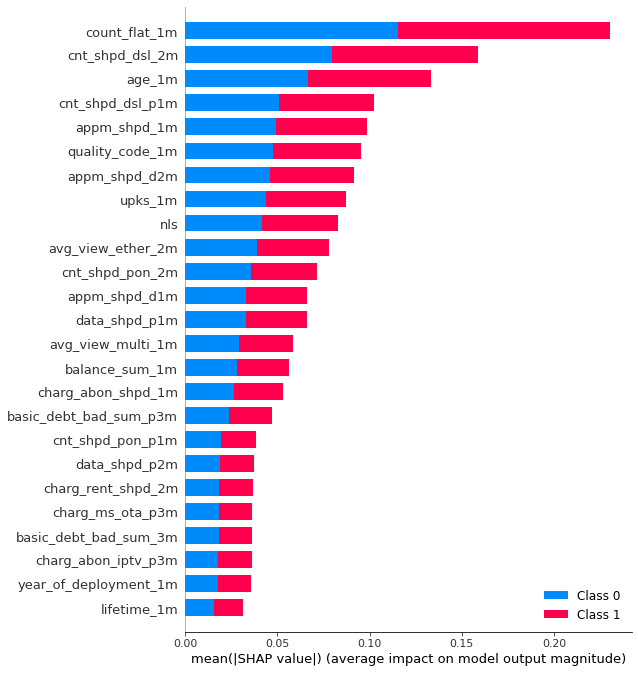

In [12]:
shap_test = shap.TreeExplainer(lgbm_clf).shap_values(df_valid.drop(columns=['label']))
shap.summary_plot(shap_test, df_valid.drop(columns=['label']),
                 max_display=25)

In [201]:
feature_columns = X_train.columns
importance = lgbm_clf.feature_importances_
feature_importance = dict(zip(feature_columns, importance))
sorted_feature_importance = sorted(feature_importance.items(), key = lambda x:x[1], reverse=True)

number_of_features_to_use = 100
features = [_[0] for _ in sorted_feature_importance[:number_of_features_to_use]]

In [202]:
features

['upks_1m',
 'count_flat_1m',
 'nls',
 'age_1m',
 'data_shpd_p2m',
 'lifetime_1m',
 'data_shpd_p1m',
 'data_shpd_d1m',
 'quality_code_1m',
 'appm_shpd_d2m',
 'house_reg_square_1m',
 'year_of_deployment_1m',
 'appm_shpd_d1m',
 'cnt_shpd_dsl_2m',
 'charg_abon_shpd_d2m',
 'basic_debt_bad_sum_p3m',
 'cnt_nls_on_hflat_1m',
 'year_of_construction_1m',
 'appm_shpd_1m',
 'appm_shpd_p2m',
 'data_shpd_p3m',
 'balance_sum_1m',
 'balance_sum_p2m',
 'cadastral_price_1m',
 'cnt_shpd_dsl_p1m',
 'charg_period_shpd_1m',
 'charg_abon_shpd_1m',
 'charg_abon_shpd_d3m',
 'data_shpd_1m',
 'data_shpd_d3m',
 'basic_debt_bad_sum_3m',
 'basic_debt_bad_sum_p2m',
 'appm_shpd_p3m',
 'cnt_ota_d1m',
 'charg_abon_shpd_p2m',
 'dur_intr_p2m',
 'dur_intr_p3m',
 'dur_intr_t_serv_3m',
 'dur_intr_d_in_2m',
 'balance_sum_d1m',
 'pay_count_p3m',
 'avg_view_multi_1m',
 'avg_view_multi_d3m',
 'avg_view_ether_2m',
 'avg_view_genre_tv_series_p3m',
 'cnt_shpd_pon_2m',
 'cnt_shpd_pon_p1m',
 'charg_period_shpd_p2m',
 'charg_abon_sh

In [203]:
X_train, y_train = df_train[features], df_train.label
X_val, y_val = df_valid[features], df_valid.label
X_test, y_test = df_test[features], df_test.label

In [98]:
param_grid = {'n_estimators' : [10, 30, 50, 100],
              'learning_rate' : [0.05, 0.1, 1],
              'reg_lambda': [0, 0.1, 0.5],
              'max_depth' : [3, 5, 7],
              'num_leaves' : [10, 25, 50],              
}

lgbm_clf = LGBMClassifier(objective='binary', metric='auc',
                          random_state=random_state )
# searcher = GridSearchCV(estimator=lgbm_clf, param_grid=param_grid, scoring='roc_auc', n_jobs=n_jobs, cv=5, verbose=10)
random_searcher = RandomizedSearchCV(estimator=lgbm_clf, param_distributions=param_grid, scoring='roc_auc',
                                     cv=5, random_state=random_state, verbose=50)

In [ ]:
random_searcher.fit(X_train, y_train)

In [100]:
roc_auc_score(y_val, random_searcher.best_estimator_.predict_proba(X_val)[:,1])

0.6701080538549585

In [101]:
roc_auc_score(y_test, random_searcher.best_estimator_.predict_proba(X_test)[:,1])

0.6689627676322711

In [ ]:
best_roc_auc = 0
for n_estimators in [10, 30, 50, 100]:
    for learning_rate in [0.05, 0.1, 1]:
        for reg_lambda in [0, 0.1, 0.5]:
            for max_depth in [3, 5, 7]:
                for num_leaves in [10, 25, 50]:
                    parameters = {'n_estimators' : n_estimators,
                                  'learning_rate' : learning_rate,
                                  'reg_lambda' : reg_lambda,
                                  'max_depth' : max_depth,
                                  'num_leaves' : num_leaves
                                 }
                    print(parameters)
                    lgbm_clf = LGBMClassifier(objective='binary', metric='auc',
            #                           class_weight='balanced',
                                      random_state=random_state,
                                         **parameters)

                    lgbm_clf.fit(X_train, y_train, eval_set=[(X_val, y_val), (X_train, y_train)], eval_metric='auc'
                                , verbose=False, early_stopping_rounds=10)
                    roc_auc = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:,1])

                    if roc_auc > best_roc_auc:
                        best_roc_auc = roc_auc
                        best_parameters = parameters
                    print(roc_auc, best_roc_auc)           

In [46]:
best_roc_auc

0.6801086892684943

In [47]:
best_parameters

{'n_estimators': 100,
 'learning_rate': 0.05,
 'reg_lambda': 0.5,
 'max_depth': 7,
 'num_leaves': 25}

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[1]	training's auc: 0.634518	valid_0's auc: 0.598291
[2]	training's auc: 0.66083	valid_0's auc: 0.639532
[3]	training's auc: 0.667571	valid_0's auc: 0.641201
[4]	training's auc: 0.682939	valid_0's auc: 0.650737
[5]	training's auc: 0.686274	valid_0's auc: 0.650664
[6]	training's auc: 0.690392	valid_0's auc: 0.652978
[7]	training's auc: 0.692529	valid_0's auc: 0.654141
[8]	training's auc: 0.696639	valid_0's auc: 0.658056
[9]	training's auc: 0.699946	valid_0's auc: 0.660444
[10]	training's auc: 0.702036	valid_0's auc: 0.663323
[11]	training's auc: 0.706104	valid_0's auc: 0.663901
[12]	training's auc: 0.706596	valid_0's auc: 0.664155
[13]	training's auc: 0.708024	valid_0's auc: 0.66507
[14]	training's auc: 0.709589	valid_0's auc: 0.666334
[15]	training's auc: 0.710011	valid_0's auc: 0.665866
[16]	training's auc: 0.711961	valid_0's auc: 0.66614
[17]	training's auc: 0.71256	valid_0's auc: 0.666124
[18]	training's auc: 0.713609	valid_0's auc: 0.666721
[19]	training's auc: 0.71498	valid_0's au

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='auc'>

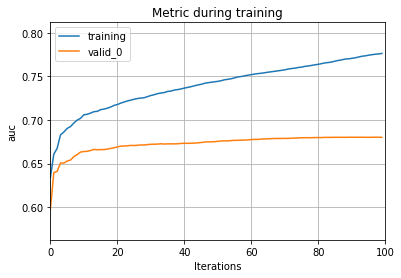

In [204]:
best_parameters = {'n_estimators': 100,
                 'learning_rate': 0.05,
                 'reg_lambda': 0.5,
                 'max_depth': 7,
                 'num_leaves': 25}

lgbm_clf = LGBMClassifier(objective='binary', metric='auc',
#                           class_weight='balanced',
                          random_state=random_state,
                         **best_parameters)

lgbm_clf.fit(X_train, y_train, eval_set=[(X_val, y_val), (X_train, y_train)], eval_metric='auc'
        , verbose=True, early_stopping_rounds=10)

plot_metric(lgbm_clf)

In [205]:
roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:,1])

0.6801086892684943

In [206]:
roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])

0.6746495168603585

In [40]:
random_searcher.best_score_

0.6967430117666774

In [32]:
random_searcher.best_params_

{'reg_lambda': 0.5,
 'num_leaves': 10,
 'n_estimators': 100,
 'max_depth': 3,
 'learning_rate': 0.1}

In [33]:
roc_auc_score(y_val, random_searcher.best_estimator_.predict_proba(X_val)[:,1])

0.6728579341319482

In [35]:
roc_auc_score(y_test, random_searcher.best_estimator_.predict_proba(X_test)[:,1])

0.6720408831530598

In [207]:
predictions_val = lgbm_clf.predict_proba(X_val)[:,1]

In [211]:
def get_metrics(df, predictions):
    results = pd.DataFrame(columns=['nls', 'labels', 'scores'])
    results['nls'], results['labels'], results['scores'] = df['nls'], df['label'], predictions
    results = results.sort_values('scores', ascending=False)
    base_churn = results.labels.mean()
    print(f'Shape: {df.shape}')
    print(f'Base churn: {base_churn}')
    print('Metrics:')
    print(f'roc_auc: {roc_auc_score(results.labels, results.scores)}')
    print(f'precision at 1%: {results[:len(results)//100].labels.mean()}')
    print(f'precision at 0.1%: {results[:len(results)//1000].labels.mean()}')
    print(f'precision at 5%: {results[:len(results)//20].labels.mean()}')
    print(f'precision at 10%: {results[:len(results)//10].labels.mean()}')
    
    print(f'lift at 0.1%: {results[:len(results)//1000].labels.mean()/base_churn}')
    print(f'lift at 1%: {results[:len(results)//100].labels.mean()/base_churn}')
    print(f'lift at 5%: {results[:len(results)//20].labels.mean()/base_churn}')
    print(f'lift at 10%: {results[:len(results)//10].labels.mean()/base_churn}')

In [212]:
get_metrics(df_valid, predictions_val)

Shape: (173304, 4301)
Base churn: 0.04113580759820893
Metrics:
roc_auc: 0.6801086892684943
precision at 1%: 0.20946335833814195
precision at 0.1%: 0.36416184971098264
precision at 5%: 0.12821696480092326
precision at 10%: 0.10778995960761685
lift at 0.1%: 8.852672913776425
lift at 1%: 5.091995771276946
lift at 5%: 3.1169186236301307
lift at 10%: 2.6203438294064285


In [115]:
predictions_test = lgbm_clf.predict_proba(X_test)[:,1]

In [213]:
get_metrics(df_test, predictions_test)

Shape: (177376, 4301)
Base churn: 0.03682008839978351
Metrics:
roc_auc: 0.6746495168603585
precision at 1%: 0.1900733220530175
precision at 0.1%: 0.2655367231638418
precision at 5%: 0.12088407758231845
precision at 10%: 0.09477363702993742
lift at 0.1%: 7.211735080065779
lift at 1%: 5.1622179715933285
lift at 5%: 3.283101231854435
lift at 10%: 2.5739654940778105


#### "Шифрование" нлс

In [172]:
nls_list = list(df_train.nls) + list(df_valid.nls) + list(df_test.nls)

In [173]:
836010273758 in nls_list

True

In [174]:
len(nls_list)

511141

In [175]:
len(set(nls_list))

201221

In [176]:
nls_set = set(nls_list)

In [128]:
number_list = [i for i in range(1, 201222)]

In [177]:
len(set(number_list))

201221

In [132]:
random.shuffle(number_list)

In [178]:
id_to_nls = {i:j for i, j in zip(number_list, nls_set)}

In [182]:
with open(f'{WORK_DIR}/id_to_nls.pickle', 'wb') as f:
    pickle.dump(id_to_nls, f)

In [5]:
with open(f'{WORK_DIR}/id_to_nls.pickle', 'rb') as f:
    id_to_nls = pickle.load(f)  

In [6]:
len(id_to_nls)

201221

In [7]:
nls_to_id = {v: k for k, v in id_to_nls.items()}

In [8]:
len(nls_to_id)

201221

In [9]:
nls_to_id[836010273758]

158504

In [24]:
# df_train = pd.read_csv(f'{WORK_DIR}/data/dataset_train.csv')
# df_train.columns = [c.split('.')[1] if '.' in c else c for c in list(df_train.columns)]
labels_train = pd.read_csv(f'{WORK_DIR}/data/labels_train.csv')
df_train = df_train.merge(labels_train, on='nls', how='inner')

In [25]:
df_train['client_id'] = [nls_to_id[i] for i in df_train['nls']]

In [26]:
df_train = df_train.drop(['nls', 'period_key', 'mrf_key', 'nls_1m'], axis=1)

In [27]:
df_train

,load_dttm_dm,hflat_1m,hlid_1m,hgid_1m,lifetime_ota_1m,lifetime_shpd_1m,lifetime_iptv_1m,lifetime_tp_ota_1m,lifetime_tp_shpd_1m,lifetime_tp_iptv_1m,...,view_time_film_fantasy_2m,view_time_film_fantasy_3m,view_time_film_fantasy_p1m,view_time_film_fantasy_p2m,view_time_film_fantasy_p3m,view_time_film_fantasy_d1m,view_time_film_fantasy_d2m,view_time_film_fantasy_d3m,label,client_id
0,2022-05-13 12:54:00.235,11726022852127600908,579093646,9107155.0,18597.0,18597.0,3031.0,18597.0,18597.0,18597.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,106606
1,2022-05-13 12:54:00.235,3368930564640238896,370185602,29928155.0,NaN,18597.0,18597.0,NaN,18597.0,18597.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,161596
2,2022-05-13 12:54:00.235,1093840297643692259,388961722,13089550.0,NaN,18597.0,366.0,NaN,18597.0,18597.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,198944
3,2022-05-13 12:54:00.235,14270383511494010742,367636608,18322138.0,18597.0,794.0,18597.0,18597.0,673.0,18597.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,188134
4,2022-05-13 12:54:00.235,918694842307981215,409108209,15069579.0,18597.0,18597.0,NaN,18597.0,18597.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,126269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160456,2022-05-13 12:54:00.235,4872285945851334720,1007447731,34013211.0,NaN,18597.0,18597.0,NaN,18597.0,18597.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,77557
160457,2022-05-13 12:54:00.235,8195474379853621154,370376609,4123739.0,NaN,18597.0,2202.0,NaN,18597.0,18597.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,112201
160458,2022-05-13 12:54:00.235,17213225661961237805,995545423,100077497.0,NaN,18597.0,723.0,NaN,18597.0,18597.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,197535
160459,2022-05-13 12:54:00.235,11876527048412749216,1025034609,23078040.0,NaN,18597.0,1730.0,NaN,18597.0,1735.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,13840


In [189]:
df_train.to_csv(f'{WORK_DIR}/data/final_train.csv')

In [160]:
df_valid = pd.read_csv(f'{WORK_DIR}/data/dataset_valid.csv')
df_valid.columns = [c.split('.')[1] if '.' in c else c for c in list(df_valid.columns)]
labels_valid = pd.read_csv(f'{WORK_DIR}/data/labels_valid.csv')
df_valid = df_valid.merge(labels_valid, on='nls', how='inner')

In [181]:
df_valid['client_id'] = [nls_to_id[i] for i in df_valid['nls']]
df_valid = df_valid.drop(['nls', 'period_key', 'mrf_key', 'nls_1m'], axis=1)

In [191]:
df_valid.to_csv(f'{WORK_DIR}/data/final_valid.csv')

In [16]:
df_test = pd.read_csv(f'{WORK_DIR}/data/dataset_predict.csv')
df_test.columns = [c.split('.')[1] if '.' in c else c for c in list(df_test.columns)] 
labels_test = pd.read_csv(f'{WORK_DIR}/data/labels_predict.csv')
df_test = df_test.merge(labels_test, on='nls', how='inner')

In [18]:
df_test['client_id'] = [nls_to_id[i] for i in df_test['nls']]
# df_test = df_test.drop(['nls', 'period_key', 'mrf_key', 'nls_1m', 'label'], axis=1)
df_test = df_test.drop(['nls', 'period_key', 'mrf_key', 'nls_1m'], axis=1)

In [19]:
df_test

,load_dttm_dm,hflat_1m,hlid_1m,hgid_1m,lifetime_ota_1m,lifetime_shpd_1m,lifetime_iptv_1m,lifetime_tp_ota_1m,lifetime_tp_shpd_1m,lifetime_tp_iptv_1m,...,view_time_film_fantasy_2m,view_time_film_fantasy_3m,view_time_film_fantasy_p1m,view_time_film_fantasy_p2m,view_time_film_fantasy_p3m,view_time_film_fantasy_d1m,view_time_film_fantasy_d2m,view_time_film_fantasy_d3m,label,client_id
0,2022-05-13 19:44:53.470,3828854658185995935,685856061,32528424.0,18901.0,18901.0,NaN,18901.0,18901.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,87887
1,2022-05-13 19:44:53.470,11886571843253804,370295107,34238475.0,NaN,18901.0,NaN,NaN,18901.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,65422
2,2022-05-13 19:44:53.470,705032194358820956,370198828,44297502.0,NaN,18901.0,NaN,NaN,18901.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,180763
3,2022-05-13 19:44:53.470,17638553000435880576,370148728,41077854.0,NaN,18901.0,NaN,NaN,18901.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,134312
4,2022-05-13 19:44:53.470,2439392963717630082,434869687,43514255.0,18901.0,151.0,NaN,18901.0,151.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,192104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177371,2022-05-13 19:44:53.470,13954492495461705486,370524927,50316933.0,NaN,18901.0,18901.0,NaN,18901.0,18901.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,32172
177372,2022-05-13 19:44:53.470,2755479529146546898,370306507,16954301.0,18901.0,594.0,18901.0,18901.0,594.0,18901.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,148717
177373,2022-05-13 19:44:53.470,9133938109827500,395330117,50345020.0,NaN,18901.0,18901.0,NaN,18901.0,18901.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71594
177374,2022-05-13 19:44:53.470,2503367274253215386,1170305184,43878667.0,NaN,1171.0,18901.0,NaN,1173.0,18901.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,23605


In [21]:
df_test.to_csv(f'{WORK_DIR}/data/final_test.csv')

In [29]:
df_test.client_id.nunique()

177376